# Evaluation
This notebook serves to showcase how the evaluation pipeline is performed. Full script can be found at `eval.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

import copy
import numpy as np
import xarray as xr

from src.causaldynamics.scm import create_scm_graph
from src.causaldynamics.plot import plot_scm
from src.causaldynamics.score import score
from src.causaldynamics.baselines import PCMCIPlus, FPCMCI, VARLiNGAM, DYNOTEARS, NGC_LSTM, TSCI, CUTSPlus

from tqdm import tqdm
from pathlib import Path


Complete script to generate the dataset can be found under `scripts/generate_<system>.py`. 

Otherwise, follow our instructions to download and process the pre-generated dataset from https://huggingface.co/datasets/kausable/CausalDynamics

In [3]:
# Once you have the dataset, either generated or downloaded
# Notice that the dataset has `time_series` and `adjacency_matrix` variables.
DATA_DIR = Path("../data/simple/noise=0.00_confounder=False/data")  # (you can change this to your own path)
ds = xr.open_dataset(DATA_DIR / "Lorenz84_N10_T1000.nc")

# Extract timeseries and adjacency matrix as target
timeseries = ds['time_series'].to_numpy().transpose(1, 0, 2) # shape of (N, T, D)
adj_matrix = ds['adjacency_matrix'].to_numpy()

# NOTE: If dataset is from coupled system e.g., "../data/coupled/...", follow these changes to load the data:
## timeseries = ds['time_series'].to_numpy()[..., 0].transpose(1, 0, 2) ## select the first dimension of each multidimensional node
## adj_matrix = ds['adjacency_matrix_summary'].to_numpy() ## `adjacency_matrix_summary` is the true adjacency matrix for coupled system


# Evaluation

Evaluate CUTS+

In [4]:
# CUTS+
tau_max = 1
corr_thres = 0.8

## Estimate adjacency matrix
cuts_adj_matrix = []
for x in tqdm(timeseries):
    cuts_model = CUTSPlus(tau_max=tau_max, corr_thres=corr_thres)
    cuts_model.run(X=x)
    cuts_adj_matrix.append(copy.deepcopy(cuts_model.adj_matrix))

## Compute scores
score(
    preds= np.array(cuts_adj_matrix),
    labs= adj_matrix,
    name='CUTS+'
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]

Scoring...


,CUTS+
Metric,
Joint AUROC,0.500000
Individual AUROC,0.500000
Null AUROC,0.500000
Joint AUPRC,0.666667
Individual AUPRC,0.666667
Null AUPRC,0.666667


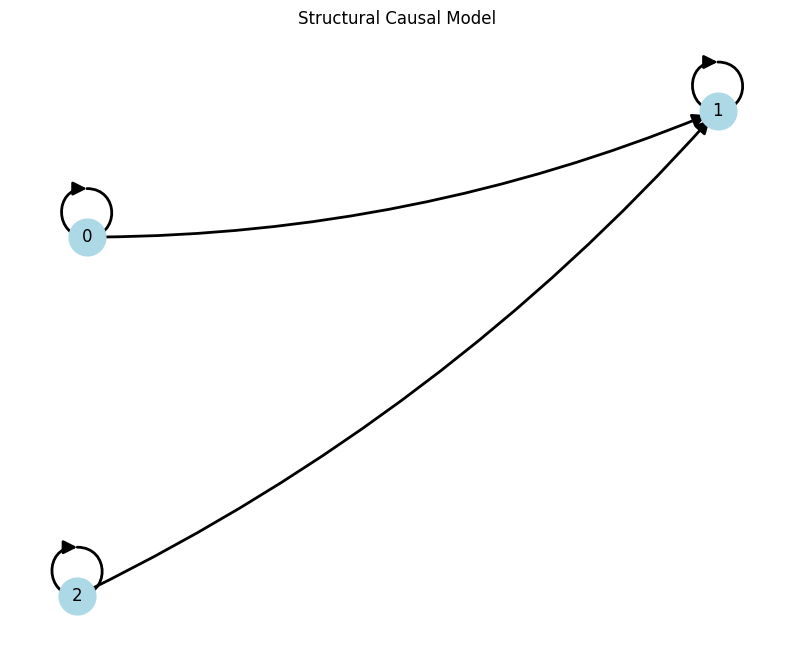

In [5]:
G = create_scm_graph(cuts_model.adj_matrix)
plot_scm(G);


Evaluate PCMCI+

In [6]:
# PCMCI+
tau_max = 1
pc_alpha = 0.01

## Estimate adjacency matrix
pcmci_plus_adj_matrix = []
for x in tqdm(timeseries):
    pcmciplus_model = PCMCIPlus(tau_max=tau_max, pc_alpha=pc_alpha)
    pcmciplus_model.run(X=x)
    pcmci_plus_adj_matrix.append(copy.deepcopy(pcmciplus_model.adj_matrix))

## Compute scores
score(
    preds= np.array(pcmci_plus_adj_matrix),
    labs= adj_matrix,
    name='PCMCI+'
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.79it/s]


Scoring...


,PCMCI+
Metric,
Joint AUROC,0.416667
Individual AUROC,0.416667
Null AUROC,0.500000
Joint AUPRC,0.631944
Individual AUPRC,0.633135
Null AUPRC,0.666667


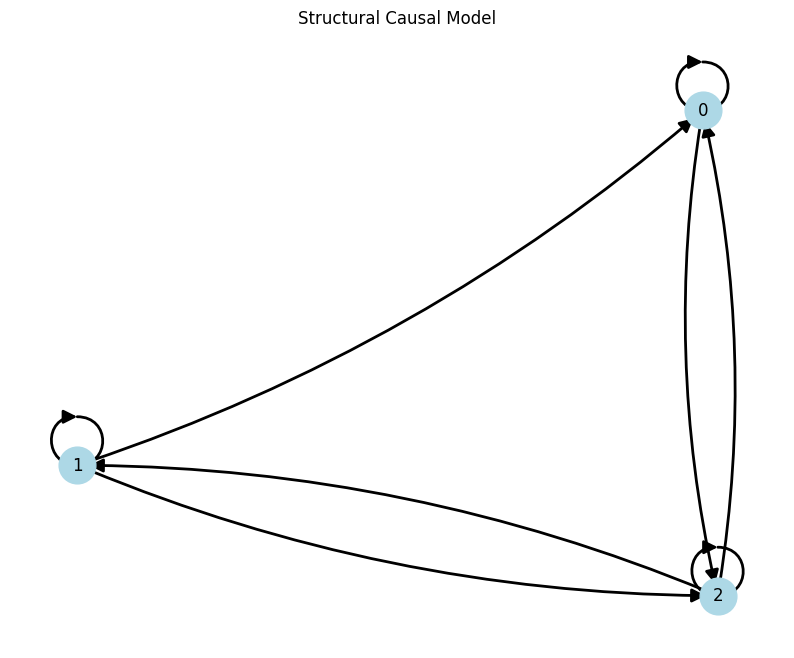

In [7]:
G = create_scm_graph(pcmciplus_model.adj_matrix)
plot_scm(G);


Evaluate VARLiNGAM

In [8]:
# VARLiNGAM
tau_max = 1

## Estimate adjacency matrix
varlingam_adj_matrix = []
for x in tqdm(timeseries):
    varlingam_model = VARLiNGAM(tau_max=tau_max)
    varlingam_model.run(X=x)
    varlingam_adj_matrix.append(copy.deepcopy(varlingam_model.adj_matrix))

## Compute scores
score(
    preds= np.array(varlingam_adj_matrix),
    labs= adj_matrix,
    name='VARLiNGAM'
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.06it/s]

Scoring...


,VARLiNGAM
Metric,
Joint AUROC,0.575000
Individual AUROC,0.575000
Null AUROC,0.500000
Joint AUPRC,0.701786
Individual AUPRC,0.704861
Null AUPRC,0.666667


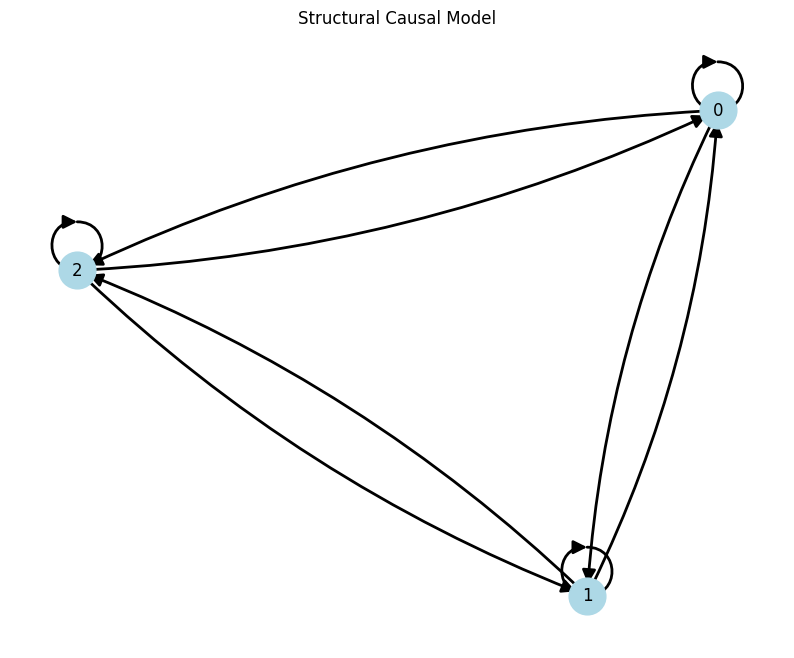

In [9]:
G = create_scm_graph(varlingam_model.adj_matrix)
plot_scm(G);


Evaluate DYNOTEARS

In [10]:
# DYNOTEARS
tau_max = 1

## Estimate adjacency matrix
dynotears_adj_matrix = []
for x in tqdm(timeseries):
    dynotears_model = DYNOTEARS(tau_max=tau_max)
    dynotears_model.run(X=x)
    dynotears_adj_matrix.append(copy.deepcopy(dynotears_model.adj_matrix))

## Compute scores
score(
    preds= np.array(dynotears_adj_matrix),
    labs= adj_matrix,
    name='DYNOTEARS'
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.94it/s]

Scoring...


,DYNOTEARS
Metric,
Joint AUROC,0.508333
Individual AUROC,0.508333
Null AUROC,0.500000
Joint AUPRC,0.670401
Individual AUPRC,0.670635
Null AUPRC,0.666667


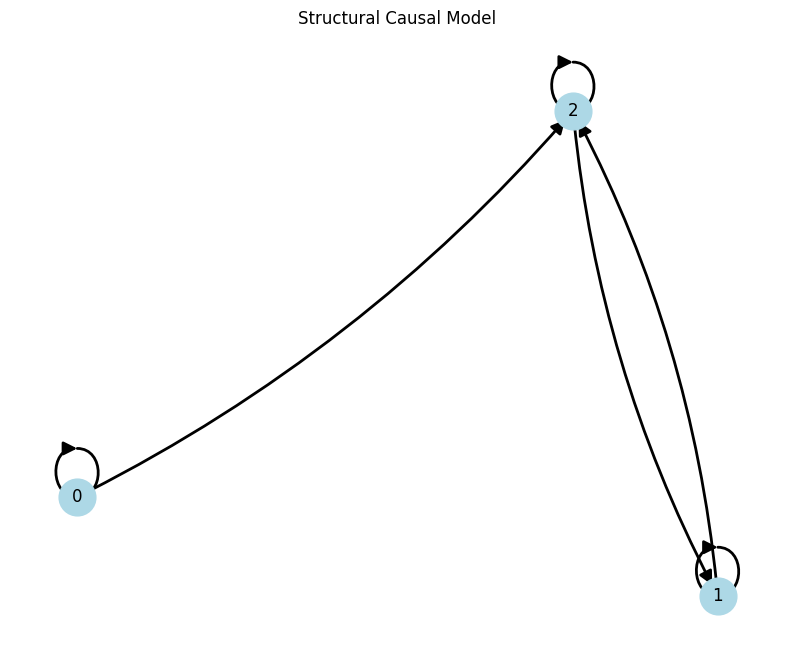

In [11]:
G = create_scm_graph(dynotears_model.adj_matrix)
plot_scm(G);


Evaluate NeuralGC (cLSTM)

In [12]:
# cLSTM
tau_max = 1

## Estimate adjacency matrix
clstm_adj_matrix = []
for x in tqdm(timeseries):
    clstm_model = NGC_LSTM(tau_max=tau_max)
    clstm_model.run(X=x)
    clstm_adj_matrix.append(copy.deepcopy(clstm_model.adj_matrix))

## Compute scores
score(
    preds= np.array(clstm_adj_matrix),
    labs= adj_matrix,
    name='cLSTM'
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]

Scoring...


,cLSTM
Metric,
Joint AUROC,0.475000
Individual AUROC,0.475000
Null AUROC,0.500000
Joint AUPRC,0.655747
Individual AUPRC,0.656845
Null AUPRC,0.666667


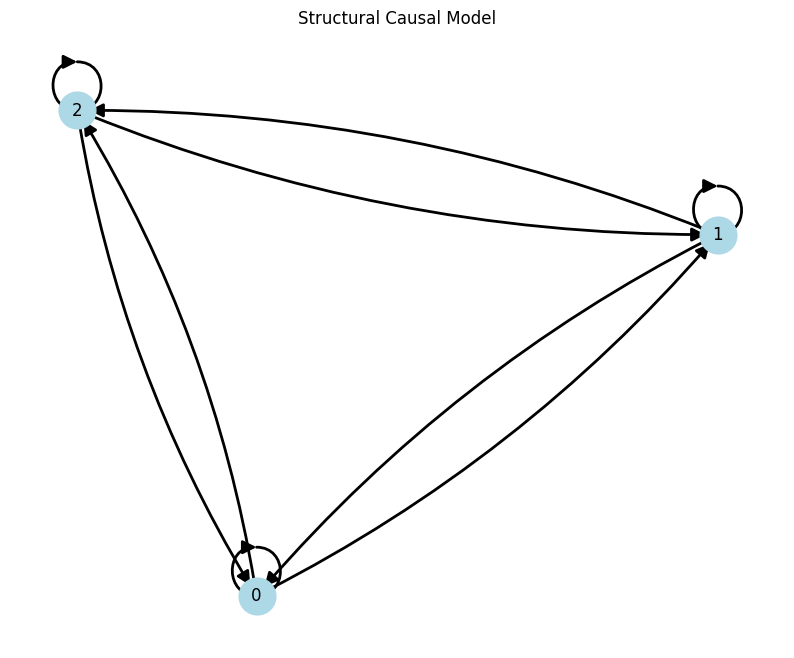

In [13]:
G = create_scm_graph(clstm_model.adj_matrix)
plot_scm(G);
